# Fraud Detection using Random Forest
This notebook demonstrates the complete pipeline for detecting fraudulent transactions using RandomForestClassifier. It includes:
- Data loading and exploration
- Stratified sampling
- Preprocessing with ColumnTransformer
- Model training and saving
- Inference and evaluation

**Python version**: 3.12.7 
**Scikit-learn version**: 1.4.2 
**Joblib version**: 1.5.1



In [1]:
# === Import all required libraries ===
import os 
import numpy as np
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,accuracy_score



## Load and Visualize Dataset
We begin by loading the fraud transaction dataset and exploring key characteristics.

In [4]:
df = pd.read_csv("Fraud.csv")

In [5]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [6]:
df.tail(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362610,742,TRANSFER,63416.99,C778071008,63416.99,0.0,C1812552860,0.00,0.00,1,0
6362611,742,CASH_OUT,63416.99,C994950684,63416.99,0.0,C1662241365,276433.18,339850.17,1,0
6362612,743,TRANSFER,1258818.82,C1531301470,1258818.82,0.0,C1470998563,0.00,0.00,1,0
6362613,743,CASH_OUT,1258818.82,C1436118706,1258818.82,0.0,C1240760502,503464.50,1762283.33,1,0
6362614,743,TRANSFER,339682.13,C2013999242,339682.13,0.0,C1850423904,0.00,0.00,1,0
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [7]:
print(f"Dataset shape:{df.shape}")


Dataset shape:(6362620, 11)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


# Fraud Occurrence by Transaction Type

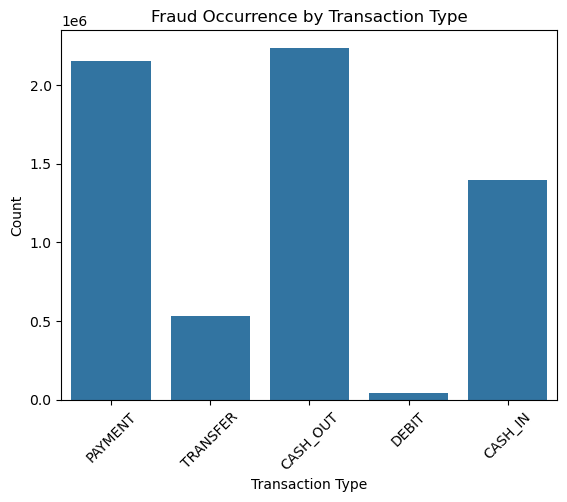

In [10]:
sns.countplot(data=df, x="type")
plt.title("Fraud Occurrence by Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


##  Model and Pipeline Filenames
These files will be used to save and load trained models and preprocessing logic.

In [12]:
MODEL_FILE = "fraud_model.pkl"
PIPELINE_FILE = "fraud_pipeline.pkl"

## Preprocessing Pipeline
We construct separate pipelines for numerical and categorical features.

In [14]:
def build_pipeline(numerical_features,categorical_features):

    num_pipeline = Pipeline([
        ("imputer",SimpleImputer(strategy="median")),
        ("scaler",StandardScaler())
    ])
    cat_pipeline = Pipeline([
        ("onehot",OneHotEncoder(handle_unknown="ignore"))
    ])
    return ColumnTransformer([
        ("num",num_pipeline,numerical_features),
        ("cat",cat_pipeline,categorical_features)
    ])

## Train Model (if not already saved)
Loads the fraud dataset, performs stratified splitting based on amount, and trains the classifier.
- Check if model exists
If not found, the script starts training from scratch.
- Prepare the dataset
Load 5,000 rows, clean missing values, stratify by amount, then split into train/test using stratified sampling.
- Train the model
Preprocess features using a pipeline and fit a RandomForestClassifier on the training data.
- Save components
Export the trained model and pipeline using joblib, and store the test set in input.csv for later use.
- Make predictions if model exists
Load saved model, pipeline, and input data; transform the data, run predictions, and save results to output.csv.


In [19]:
if not os.path.exists(MODEL_FILE):

    #load dataset
    df = pd.read_csv("Fraud.csv")

    # Drop rows where 'amount' or 'isFraud' is missing
    df = df.dropna(subset=["amount", "isFraud"])

    # Reset index to avoid KeyError during sampling
    df.reset_index(drop=True, inplace=True)


    #create stratified amount 
    df["amount_group"] = pd.cut(df["amount"], bins=[0, 50, 200, 500, 2000, np.inf],
                                labels=[1, 2, 3, 4, 5])
    df = df.dropna(subset=["amount_group"])
    print("Amount_gruop Create Successfully... ")
    
    # Perform stratified sampling
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, test_idx in splitter.split(df, df["amount_group"]):
        train_set = df.iloc[train_idx].drop("amount_group", axis=1)
        test_set = df.iloc[test_idx].drop("amount_group", axis=1)

    # Save test set for inference
    test_set.to_csv("input.csv", index=False)

    # Separate labels and features
    y_train = train_set["isFraud"].fillna(train_set["isFraud"].mode()[0]).astype(int)
    X_train = train_set.drop(["isFraud", "isFlaggedFraud"], axis=1)
    print(" Separate labels and features successfully....")
    
    # Define feature categories
    numeric_cols = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
    categorical_cols = ["type", "nameOrig", "nameDest"]

     # Build pipeline and preprocess
    pipeline = build_pipeline(numeric_cols, categorical_cols)
    X_train_prepared = pipeline.fit_transform(X_train)
    print(" X_train_prepared Successfully")

    # Train classifier
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_prepared, y_train)
    print("Model fit Successfully")

    # Save pipeline and model
    joblib.dump(model, MODEL_FILE)
    joblib.dump(pipeline, PIPELINE_FILE)

    print("Model trained and saved.")


## Load Model and Predict
#Saved model and pipeline are used to infer fraud probabilities on the test set.

else:
    #load saved model and pipeline
    model = joblib.load(MODEL_FILE)
    pipeline = joblib.load(PIPELINE_FILE) 

    #load test data
    input_data = pd.read_csv("input.csv")
    X_input = input_data.drop(["isFraud","isFlaggedFraud"],axis=1)
    
    #Transform data
    X_transformed = pipeline.transform(X_input)

    #Make prediction
    predictions = model.predict(X_transformed)
    input_data["predicted_fraud"] = predictions

    #saved output
    input_data.to_csv("output.csv",index=False)
    print("Inference complete. Output saved to output.csv")



Inference complete. Output saved to output.csv


## Model Evaluation
We assess accuracy, ROC-AUC.

In [25]:
# Load true labels from test set
y_true = input_data["isFraud"].astype(int)

# Compare with predictions
accuracy = accuracy_score(y_true, predictions)

print(f"Model Accuracy on Test Set: {accuracy:.4f}")

Model Accuracy on Test Set: 0.9800
